In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno

import plotly.express as px
import plotly.graph_objects as go
import statistics
from datetime import timedelta, datetime
from geopy import distance

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

sns.set_theme()

### Try to find the effect of spraying on number of mosquitos in time aspect

In [96]:
train_df = pd.read_csv('../data/train.csv')
spray_df = pd.read_csv('../data/spray.csv')

In [97]:
train_df['Date'] = pd.to_datetime(train_df['Date'])

In [98]:
spray_df['Date'] = pd.to_datetime(spray_df['Date'])

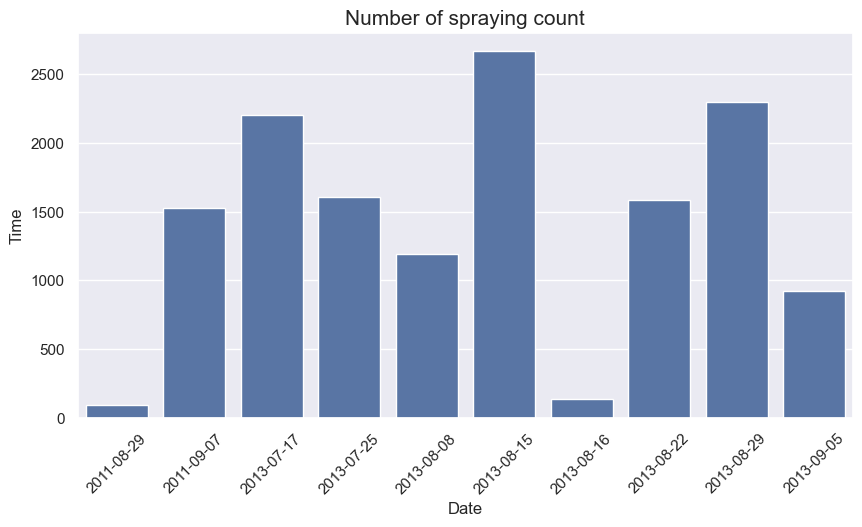

In [109]:
# Spray times in each date
plt.figure(figsize=(10, 5))
plt.xticks(rotation=45)
plt.title('Number of spraying count', size=15)
sns.barplot(spray_df.groupby(spray_df['Date'], as_index=False).count(), x='Date', y='Time');

In [6]:
spray_df = spray_df[['Date', 'Latitude' , 'Longitude']].drop_duplicates()
spray_df['Date'] = pd.to_datetime(spray_df['Date'])
spray_df.head()

,Date,Latitude,Longitude
0,2011-08-29,42.391623,-88.089163
1,2011-08-29,42.391348,-88.089163
2,2011-08-29,42.391022,-88.089157
3,2011-08-29,42.390637,-88.089158
4,2011-08-29,42.390410,-88.088858


In [7]:
# Create weeknum & year
spray_df['weeknum'] = spray_df['Date'].dt.strftime("%U").astype(int)
spray_df['year'] = spray_df['Date'].dt.year

In [8]:
spray_df

,Date,Latitude,Longitude,weeknum,year
0,2011-08-29,42.391623,-88.089163,35,2011
1,2011-08-29,42.391348,-88.089163,35,2011
2,2011-08-29,42.391022,-88.089157,35,2011
3,2011-08-29,42.390637,-88.089158,35,2011
4,2011-08-29,42.390410,-88.088858,35,2011
...,...,...,...,...,...
14830,2013-09-05,42.006587,-87.812355,35,2013
14831,2013-09-05,42.006192,-87.816015,35,2013
14832,2013-09-05,42.006022,-87.817392,35,2013
14833,2013-09-05,42.005453,-87.817423,35,2013


In [9]:
# Prepare plot data, number of mosquitos and WnvPresent over time
# Sum NumMosquitos and WnvPresent from multiple splitted record
animate_df = train_df.copy()
col = list(animate_df.drop(columns=['NumMosquitos', 'WnvPresent']).columns)
animate_df = animate_df.groupby(col, as_index=False)[['NumMosquitos', 'WnvPresent']].sum()
animate_df = animate_df[['Date', 'Latitude', 'Longitude', 'NumMosquitos', 'WnvPresent', 'Species']]
animate_df

,Date,Latitude,Longitude,NumMosquitos,WnvPresent,Species
0,2007-05-29,41.867108,-87.654224,1,0,CULEX PIPIENS/RESTUANS
1,2007-05-29,41.867108,-87.654224,2,0,CULEX RESTUANS
2,2007-05-29,41.862292,-87.648860,1,0,CULEX RESTUANS
3,2007-05-29,41.896282,-87.655232,1,0,CULEX RESTUANS
4,2007-05-29,41.907645,-87.760886,1,0,CULEX RESTUANS
...,...,...,...,...,...,...
8470,2013-09-26,41.726465,-87.585413,6,0,CULEX PIPIENS
8471,2013-09-26,41.726465,-87.585413,4,0,CULEX PIPIENS/RESTUANS
8472,2013-09-26,41.723195,-87.649970,4,0,CULEX PIPIENS/RESTUANS
8473,2013-09-26,41.868077,-87.666901,2,0,CULEX PIPIENS/RESTUANS


In [10]:
# Correcting WnvPresent values
animate_df['WnvPresent'] = animate_df['WnvPresent'].map(lambda x: 0 if x == 0 else 1)

In [11]:
# Create year_month and year_week for visualization
animate_df['weeknum'] = animate_df['Date'].dt.strftime("%U").astype(int)
animate_df['year'] = animate_df['Date'].dt.year
animate_df['year_month'] = animate_df.apply(lambda x: str(x['Date'].year) + str(x['Date'].month).zfill(2), axis=1)
animate_df['year_week'] = animate_df.apply(lambda x: str(x['year']) + str(x['weeknum']).zfill(2), axis=1)
animate_df

,Date,Latitude,Longitude,NumMosquitos,WnvPresent,Species,weeknum,year,year_month,year_week
0,2007-05-29,41.867108,-87.654224,1,0,CULEX PIPIENS/RESTUANS,21,2007,200705,200721
1,2007-05-29,41.867108,-87.654224,2,0,CULEX RESTUANS,21,2007,200705,200721
2,2007-05-29,41.862292,-87.648860,1,0,CULEX RESTUANS,21,2007,200705,200721
3,2007-05-29,41.896282,-87.655232,1,0,CULEX RESTUANS,21,2007,200705,200721
4,2007-05-29,41.907645,-87.760886,1,0,CULEX RESTUANS,21,2007,200705,200721
...,...,...,...,...,...,...,...,...,...,...
8470,2013-09-26,41.726465,-87.585413,6,0,CULEX PIPIENS,38,2013,201309,201338
8471,2013-09-26,41.726465,-87.585413,4,0,CULEX PIPIENS/RESTUANS,38,2013,201309,201338
8472,2013-09-26,41.723195,-87.649970,4,0,CULEX PIPIENS/RESTUANS,38,2013,201309,201338
8473,2013-09-26,41.868077,-87.666901,2,0,CULEX PIPIENS/RESTUANS,38,2013,201309,201338


In [12]:
# Create new df, spray with decay time
spray_df_with_decay = spray_df[['Latitude', 'Longitude', 'weeknum', 'year']].copy()
spray_df_with_decay['spray_decay_weight'] = 0
new_row_index = spray_df_with_decay.index.max() + 1
new_rows = []

for row in spray_df.iterrows():
    for i in range(8):
        new_rows.append({
            'Latitude': row[1]['Latitude'],
            'Longitude': row[1]['Longitude'],
            'weeknum': row[1]['weeknum'] + i,
            'year': row[1]['year'],
            'spray_decay_weight': i
        })
        new_row_index += 1
    
spray_df_with_decay = pd.concat([spray_df_with_decay, pd.DataFrame(new_rows)])

In [13]:
animate_df

,Date,Latitude,Longitude,NumMosquitos,WnvPresent,Species,weeknum,year,year_month,year_week
0,2007-05-29,41.867108,-87.654224,1,0,CULEX PIPIENS/RESTUANS,21,2007,200705,200721
1,2007-05-29,41.867108,-87.654224,2,0,CULEX RESTUANS,21,2007,200705,200721
2,2007-05-29,41.862292,-87.648860,1,0,CULEX RESTUANS,21,2007,200705,200721
3,2007-05-29,41.896282,-87.655232,1,0,CULEX RESTUANS,21,2007,200705,200721
4,2007-05-29,41.907645,-87.760886,1,0,CULEX RESTUANS,21,2007,200705,200721
...,...,...,...,...,...,...,...,...,...,...
8470,2013-09-26,41.726465,-87.585413,6,0,CULEX PIPIENS,38,2013,201309,201338
8471,2013-09-26,41.726465,-87.585413,4,0,CULEX PIPIENS/RESTUANS,38,2013,201309,201338
8472,2013-09-26,41.723195,-87.649970,4,0,CULEX PIPIENS/RESTUANS,38,2013,201309,201338
8473,2013-09-26,41.868077,-87.666901,2,0,CULEX PIPIENS/RESTUANS,38,2013,201309,201338


In [14]:
spray_df_with_decay

,Latitude,Longitude,weeknum,year,spray_decay_weight
0,42.391623,-88.089163,35,2011,0
1,42.391348,-88.089163,35,2011,0
2,42.391022,-88.089157,35,2011,0
3,42.390637,-88.089158,35,2011,0
4,42.390410,-88.088858,35,2011,0
...,...,...,...,...,...
114347,42.004805,-87.817460,38,2013,3
114348,42.004805,-87.817460,39,2013,4
114349,42.004805,-87.817460,40,2013,5
114350,42.004805,-87.817460,41,2013,6


In [15]:
# Calculate distace from spray point
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Radius of Earth in kilometers (you can use 3956 for miles)
    R = 6371
    
    # Calculate the distance
    distance = R * c
    
    return distance

def cal_distance(df, lat, lon):
    df = pd.concat([df, pd.DataFrame(lat, index=df.index, columns=['lat'])], axis=1)
    df = pd.concat([df, pd.DataFrame(lon, index=df.index, columns=['lon'])], axis=1)
    # df['lat'] = lat
    # df['lon'] = lon
    return haversine(df['Latitude'], df['Longitude'], df['lat'], df['lon'])

# Calculate distances for the entire DataFrame
for row in animate_df[['Latitude', 'Longitude']].drop_duplicates().iterrows():
    row_location = (row[1]['Latitude'], row[1]['Longitude'])

    spray_df_with_decay = pd.concat([spray_df_with_decay, pd.DataFrame(np.nan, index=spray_df_with_decay.index, columns=['distance_from' + str(row_location)])], axis=1)
    spray_df_with_decay.loc[:, 'distance_from' + str(row_location)] = cal_distance(spray_df_with_decay[['Latitude', 'Longitude']], row[1]['Latitude'], row[1]['Longitude'])

In [16]:
animate_df

,Date,Latitude,Longitude,NumMosquitos,WnvPresent,Species,weeknum,year,year_month,year_week
0,2007-05-29,41.867108,-87.654224,1,0,CULEX PIPIENS/RESTUANS,21,2007,200705,200721
1,2007-05-29,41.867108,-87.654224,2,0,CULEX RESTUANS,21,2007,200705,200721
2,2007-05-29,41.862292,-87.648860,1,0,CULEX RESTUANS,21,2007,200705,200721
3,2007-05-29,41.896282,-87.655232,1,0,CULEX RESTUANS,21,2007,200705,200721
4,2007-05-29,41.907645,-87.760886,1,0,CULEX RESTUANS,21,2007,200705,200721
...,...,...,...,...,...,...,...,...,...,...
8470,2013-09-26,41.726465,-87.585413,6,0,CULEX PIPIENS,38,2013,201309,201338
8471,2013-09-26,41.726465,-87.585413,4,0,CULEX PIPIENS/RESTUANS,38,2013,201309,201338
8472,2013-09-26,41.723195,-87.649970,4,0,CULEX PIPIENS/RESTUANS,38,2013,201309,201338
8473,2013-09-26,41.868077,-87.666901,2,0,CULEX PIPIENS/RESTUANS,38,2013,201309,201338


In [17]:
# Get nearby spray decay time for each point in animate_df
def get_spray_decay_time_from_nearby(row, km):
    try:
        return spray_df_with_decay[(spray_df_with_decay['weeknum'] == row['weeknum']) & (spray_df_with_decay['year'] == row['year']) & (spray_df_with_decay['distance_from' + str((row['Latitude'], row['Longitude']))] < km)]['spray_decay_weight'].min()
    except:
        return -1

animate_df['nearby_spray_decay_time_within_1km'] = animate_df.apply(lambda x: get_spray_decay_time_from_nearby(x, 1), axis=1)
animate_df['nearby_spray_decay_time_within_2km'] = animate_df.apply(lambda x: get_spray_decay_time_from_nearby(x, 2), axis=1)
animate_df['nearby_spray_decay_time_within_5km'] = animate_df.apply(lambda x: get_spray_decay_time_from_nearby(x, 5), axis=1)
animate_df.fillna(-1, inplace=True)

In [110]:
# Visualize spray comparing with number of mosquitos and Wnv Present
def visualize_spray(animate_df, spray_df, year_week_start, year_week_end, spray_index=0):
    # incase spray df din't prep
    # split Date into year_week
    spray_df['year'] = spray_df['Date'].dt.year.astype(int)
    spray_df['weeknum'] = spray_df['Date'].dt.strftime("%U").astype(int)
    spray_df['year_week'] = spray_df.apply(lambda x: str(x['year']) + str(x['weeknum']).zfill(2), axis=1)

    # Spray area
    spray_fig = px.scatter_mapbox(
        data_frame=spray_df[spray_df['year_week'].between(year_week_start, year_week_end)],
        lat="Latitude", lon="Longitude",
        zoom=9.5,
        color='year_week',
        height=800, width=800,
        mapbox_style='open-street-map')

    wnv_fig = px.scatter_mapbox(
        data_frame=animate_df[animate_df['year_week'].between(year_week_start, year_week_end)],
        lat="Latitude", lon="Longitude",
        zoom=9.5,
        hover_name='Species',
        size='NumMosquitos',
        color='WnvPresent',
        size_max=80,
        animation_frame='year_week',
        range_color=[0, 1],
        height=800, width=800,
        mapbox_style='open-street-map',
        title='Spray area vs mosquitoes with/without Wnv',
    )
    # add color to spray_fig for add_Trace
    # for i in spray_df.groupby('year_week').count().reset_index().index:
   
    if spray_index == -1:
        for data in spray_fig.data:
            wnv_fig.add_trace(data)
    else:
        wnv_fig.add_trace(spray_fig.data[spray_index])

    wnv_fig.update_layout(
        legend=dict(
            x=0, y=-0.02,  # Adjust these values to position the legend
            traceorder='normal',
            orientation='h'
        )
    )
    
    wnv_fig.show();

In [111]:
# visualize_spray(animate_df, spray_df, '201300', '201400', 1)
# visualize_spray(animate_df, spray_df, '201300', '201400', 2)
visualize_spray(animate_df, spray_df, '201300', '201400', -1)

In [20]:
# Index for spray location
spray_df.groupby('year_week').count().reset_index()

,year_week,Date,Latitude,Longitude,weeknum,year
0,201135,95,95,95,95,95
1,201136,1573,1573,1573,1573,1573
2,201328,2202,2202,2202,2202,2202
3,201329,1607,1607,1607,1607,1607
4,201331,1195,1195,1195,1195,1195
5,201332,2809,2809,2809,2809,2809
6,201333,1587,1587,1587,1587,1587
7,201334,2302,2302,2302,2302,2302
8,201335,924,924,924,924,924


In [102]:
# Visualize number of mosquito with spraying decay time
fig = px.scatter_mapbox(
    data_frame=animate_df[animate_df['year'] == 2013],
    lat="Latitude", lon="Longitude",
    zoom=9.5,
    hover_name='Species',
    size='NumMosquitos',
    color='nearby_spray_decay_time_within_1km',
    size_max=80,
    animation_frame='year_week',
    range_color=[-1, 7],
    height=800, width=1200,
    mapbox_style='open-street-map',
    title='Number of mosquitoes in areas with decay time of spray'
)

fig.show()

### Spraying Cost Projection

In [22]:
# Load data
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
predict = pd.read_csv('../data/cost_effective_analysis/submission_lr.csv')
predict_proba = pd.read_csv('../data/cost_effective_analysis/submission_lr_Proba.csv')
predict_proba.rename(columns={'WnvPresent': 'WnvProba'}, inplace=True)

In [23]:
test_df = test_df.merge(predict).merge(predict_proba)
test_df.head()

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,WnvPresent,WnvProba
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,0.037209
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,0.013964
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,0.052963
3,4,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX SALINARIUS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,0.000029
4,5,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX TERRITANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,0,0.000023


In [24]:
col = list(train_df.drop(columns=['NumMosquitos']).columns)
train_df = train_df.groupby(col, as_index=False)['NumMosquitos'].sum()
train_df.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,WnvPresent,NumMosquitos
0,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,0,1
1,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,0,2
2,2007-05-29,"1100 South Peoria Street, Chicago, IL 60608, USA",CULEX RESTUANS,11,S PEORIA ST,T091,"1100 S PEORIA ST, Chicago, IL",41.862292,-87.648860,8,0,1
3,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,0,1
4,2007-05-29,"1500 North Long Avenue, Chicago, IL 60651, USA",CULEX RESTUANS,15,N LONG AVE,T153,"1500 N LONG AVE, Chicago, IL",41.907645,-87.760886,8,0,1


In [25]:
train_df['Date'] = pd.to_datetime(train_df['Date'])

In [26]:
# Use August 2013 as the worst case scenario
aug_wnv_present = train_df.loc[(train_df['WnvPresent'] == 1) & (train_df['Date'] == '2013-08'), ['Latitude', 'Longitude', 'WnvPresent', 'NumMosquitos']].groupby(['Latitude', 'Longitude', 'WnvPresent'], as_index=False).sum()
aug_wnv_present.rename(columns={'NumMosquitos': 'NumMosquitos_with_Wnv'}, inplace=True)

aug_wnv_not_present = train_df.loc[(train_df['WnvPresent'] == 0) & (train_df['Date'] == '2013-08'), ['Latitude', 'Longitude', 'WnvPresent', 'NumMosquitos']].groupby(['Latitude', 'Longitude', 'WnvPresent'], as_index=False).sum()
aug_wnv_not_present.rename(columns={'NumMosquitos': 'NumMosquitos_no_Wnv'}, inplace=True)

aug_mosquitos_df = aug_wnv_present.drop(columns='WnvPresent').merge(aug_wnv_not_present.drop(columns='WnvPresent'), on=['Latitude', 'Longitude'], how='outer')

In [27]:
# Calculate percent of mosquitos with virus (assume that all mosquitos in the same trap with WnvPresent = 1 have virus)
def cal_wnv_percentage(row):
    if np.isnan(row['NumMosquitos_with_Wnv']) and np.isnan(row['NumMosquitos_no_Wnv']):
        return 0
    elif np.isnan(row['NumMosquitos_no_Wnv']):
        return 1
    elif np.isnan(row['NumMosquitos_with_Wnv']):
        return 0
    else:
        return row['NumMosquitos_with_Wnv'] / (row['NumMosquitos_with_Wnv'] + row['NumMosquitos_no_Wnv'])
    
aug_mosquitos_df['WnvPercentage'] = aug_mosquitos_df.apply(cal_wnv_percentage, axis=1)
print(aug_mosquitos_df.isna().sum())
aug_mosquitos_df.head()

Latitude                  0
Longitude                 0
NumMosquitos_with_Wnv    59
NumMosquitos_no_Wnv       2
WnvPercentage             0
dtype: int64


,Latitude,Longitude,NumMosquitos_with_Wnv,NumMosquitos_no_Wnv,WnvPercentage
0,41.659112,-87.538693,5.0,81.0,0.058140
1,41.720848,-87.666014,4.0,NaN,1.000000
2,41.728495,-87.600963,21.0,11.0,0.656250
3,41.743402,-87.731435,27.0,1.0,0.964286
4,41.899230,-87.716788,46.0,16.0,0.741935


In [28]:
print(f'Average percentage of mosquitos with virus is {round(aug_mosquitos_df["WnvPercentage"].mean()*100, 2)}%')

Average percentage of mosquitos with virus is 9.91%


In [29]:
# Read wnv probability data generated from model
wnv_proba_df = pd.read_csv('../data/cost_effective_analysis/wnv_proba.csv')

In [30]:
# Minimum proba from model that WnvPresent = 1
wnv_proba_df[wnv_proba_df['WnvPresent'] == 1]['Proba'].min()

0.10483796772103

In [31]:
# Average proba from model that WnvPresent = 1
wnv_proba_df[wnv_proba_df['WnvPresent'] == 1]['Proba'].mean()

0.6184482250761151

In [ ]:
# Cost and benefit tradeoff
min_model_proba = wnv_proba_df[wnv_proba_df['WnvPresent'] == 1]['Proba'].min() # 0.1098566500067786
avg_model_proba = wnv_proba_df[wnv_proba_df['WnvPresent'] == 1]['Proba'].mean() # 0.6186123672630235

proba_threshold = [min_model_proba, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9]
result = []

for thres in proba_threshold:
    spray_loc = test_df[(test_df['WnvPresent'] == 1) & (test_df['WnvProba'] >= thres)][['Latitude', 'Longitude']].drop_duplicates()
    all_loc = test_df[(test_df['WnvPresent'] == 1)][['Latitude', 'Longitude']].drop_duplicates()
    missing_loc_count = all_loc.shape[0] - all_loc.merge(spray_loc, on=['Latitude', 'Longitude']).count().iloc[0]

    result.append({
        'Threshold': str(round(thres*100, 2)) + '%', # Threshold to predict whether the location have Wnv or not, then trust the prediction and spray that area
        '# locations to be sprayed': test_df[test_df['WnvProba'] >= thres][['Latitude', 'Longitude']].drop_duplicates().shape[0],
        'Missing locations': str(round(missing_loc_count/all_loc.shape[0]*100, 2)) + '%'
    })

pd.DataFrame(result)

    # print(f'[Spray location with Wnv probs from model >= {round(thres*100, 2)}%]')
    # print('Locations to be sprayed:', test_df[test_df['WnvProba'] >= thres][['Latitude', 'Longitude']].drop_duplicates().shape[0])    
    # print(f'Missing locations (have Wnv but not sprayed): {round(missing_loc_count/all_loc.shape[0]*100, 2)}%\n')

    # Confusion Matrix of validate set
    # ConfusionMatrixDisplay(confusion_matrix(wnv_proba_df['WnvPresent'], wnv_proba_df['Proba'].map(lambda x: 1 if x >= thres else 0))).plot()
    # plt.grid(False)
    # plt.show();

,Threshold,# locations to be sprayed,Missing locations
0,10.48%,151,0.0%
1,82.0%,151,0.0%
2,83.0%,144,4.64%
3,84.0%,137,9.27%
4,85.0%,125,17.22%
5,86.0%,110,27.15%
6,87.0%,95,37.09%
7,88.0%,75,50.33%
8,89.0%,53,64.9%
9,90.0%,30,80.13%
